# Projeto Final - 2018  

## X-ray Pneumonia Classification

* Felipe Souza
* Pedro Augusto
* Rafael Dias
* Sergio Marinello


## Problema
### Variação do Xception - Transfer Learning  (NORMAL, PNEUMONIA BACTERIANA e PNEUMONIA VIRAL)<br>usando CNN simples com 3 camadas convolucionais + 1 densa + 1 densa para classificaço comã softmax

1. Healthy 
2. Pneumonia viral 
3. Pneumonia bacterial

### Data
#### Data Source
O dataset pode ser obtido em:
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia


#### Estrutura dos dados
O dataset contido em um arquivo  zip contém a estrutura de diretórios que provê a divisão de treinamento, validação e teste totalizando 5.863 imagens.
 
Abaixo temos a estrutura de pastas, que representa a divisão de teste, treinamento e validação e classe de cada imagem.

* /chest_xray/  
  * test/
    * NORMAL/
    * PNEUMONIA/
  * train/
    * NORMAL/
    * PNEUMONIA/
  * val/
    * NORMAL/
    * PNEUMONIA/


In [1]:
!pip install imgaug

In [2]:
ROOT_DIR = "../input" #kaggle/git dir
SRC_DIR = "./" #root dir

# Import library
import os
if not (os.path.exists(ROOT_DIR)):
    print("Using git repository")
    ROOT_DIR = "./kowaslki/input" #colab dir
    SRC_DIR = "./kowaslki/src" #colab dir
    if not (os.path.exists(ROOT_DIR)):    
        print("Checking out git repository")
        !git clone https://gitlab.com/rafa.apps/kowaslki.git
else:
    print("Using kaggle repository")
  

Using kaggle repository



```
# This is formatted as code
```

## Verificação dos dados

In [3]:
%matplotlib inline

# Basic math libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

MODEL_ID = "model_8.1_xception_CNN6_augmet"

# percentual do número de imagens usado por step no treinamento
TRAINING_PERCENTAGE = 1.0

# Take note that the .7z directory name is automatically converted to lowercase. 
INPUT_DIR = '%s/chest_xray/chest_xray' % ROOT_DIR


import os.path
# Ensure we're reading the directory correctly.
assert (os.path.exists(INPUT_DIR))

First, locate the main directory and display its content.

In [4]:
directory = os.listdir(INPUT_DIR)
print("Parent directory includes these folders:", directory)

('Parent directory includes these folders:', ['.DS_Store', 'test', 'train', 'val'])


The folders are split to include train, testing, as well as validation. Create variables pointing to these subfolders

In [5]:
train_folder = '%s/train/' % INPUT_DIR 
val_folder   = '%s/val/' % INPUT_DIR
test_folder  = '%s/test/' % INPUT_DIR

Define the two training class folders of Normal and Pneumonia.

## Carrega UTILS


In [6]:
DATASET_UTILS = '%s/dataset_utils' % SRC_DIR
%run $DATASET_UTILS

Using TensorFlow backend.


### Métodos Utilitários do Dataset

In [7]:
nbClasses = 3

# classes
NORMAL=0
BACTERIA=1
VIRUS=2

def getLabelFromImgName(imgName):
    if "bacteria" in imgName:
        return BACTERIA
    if "virus" in imgName:
        return VIRUS
    return NORMAL

#http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          width=8,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    f, ax = plt.subplots(1, 1, figsize=(width, width))
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(classes, rotation=90)
    ax.set_yticklabels(classes)
    ax.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    #axis[ax].axis('off')
    plt.tight_layout()
    return cm

## Carregando Dataset 

### Decidimos utilizar nosso dataset balanceando as classes de validação

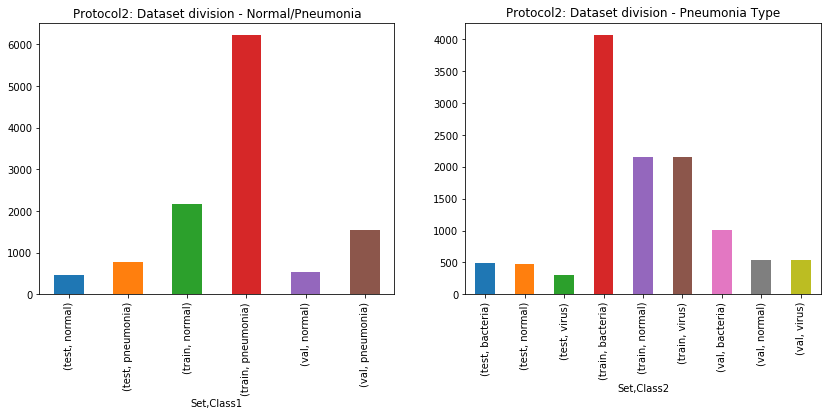

In [8]:
df_protocol2 = load_df('alternative', root_path="./")

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
ax1.set_title('Protocol2: Dataset division - Normal/Pneumonia')
ax2.set_title('Protocol2: Dataset division - Pneumonia Type')
_ = (df_protocol2.groupby(by=['Set', 'Class1']).size()).plot('bar', ax=ax1)
_ = (df_protocol2.groupby(by=['Set', 'Class2']).size()).plot('bar', ax=ax2)

In [9]:
from collections import defaultdict, Counter

for phase in df_protocol2.Set.unique():
    print('%s distribution: %s' % (phase, str(Counter(df_protocol2[df_protocol2.Set == phase].Class1))))
    print('%s distribution: %s' % (phase, str(Counter(df_protocol2[df_protocol2.Set == phase].Class2))))
    print('\n')

nan distribution: Counter()
nan distribution: Counter()


test distribution: Counter({'pneumonia': 780, 'normal': 468})
test distribution: Counter({'bacteria': 484, 'normal': 468, 'virus': 296})


train distribution: Counter({'pneumonia': 6212, 'normal': 2158})
train distribution: Counter({'bacteria': 4060, 'normal': 2158, 'virus': 2152})


val distribution: Counter({'pneumonia': 1554, 'normal': 540})
val distribution: Counter({'bacteria': 1016, 'normal': 540, 'virus': 538})




### Observamos que os de treinamento dados são altamente desbalanceados, além disso as dimensões das imagens não são sempre iguais.<br>Dessa forma, precisamos ponderar o peso para treinamento.<br><br>Além disso, observamos que o conjunto de validação é razoavelmente pequeno.

### Gera image loaders

In [10]:
img_width, img_height = 229,229

from keras import backend as K

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)


In [11]:

#Read our dataset in batches

class DataLoaderSig(Sequence):
    def __init__(self, df = None,  batch_size=32,
                 nb_classes=nbClasses, 
                 stratify=None,
                 image_shape=(112, 112), 
                 dataAugmentator=None, 
                 shuffle=True, 
                 normalization_fn=None,
                 load_and_preprocess_fn=None, 
                 path_and_class_translation_fn=None):
        self.df = df
        self.image_shape = image_shape
        self.dataAugmentator = dataAugmentator
        self.shuffle = shuffle
        self.nb_classes = nb_classes
        self.normalization_fn = normalization_fn
        self.load_and_preprocess_fn = load_and_preprocess_fn
        self.path_and_class_translation_fn = path_and_class_translation_fn
        self.num_stratums = len(df[stratify].unique())
        self.partial_batch_size = batch_size // self.num_stratums

        indexes = {clazz: df[df[stratify] == clazz].index.tolist() for clazz in df[stratify].unique()}
        max_size = max(map(len, indexes.values()))
        self.size = max_size
        self.indexes = {clazz: np.random.choice(values, size=max_size, replace=True) for clazz, values in indexes.items()}
        if self.shuffle:
            self.indexes = {clazz: np.random.permutation(values) for clazz, values in self.indexes.items()}

    def __len__(self):
        return int(np.ceil(self.size / self.partial_batch_size))

    def __getitem__(self, index):
        # Generate indexes of the batch
        batch_indexes = []
        for key, stratum_indexes in self.indexes.items():
            batch_indexes.append(stratum_indexes[index*self.partial_batch_size:(index+1)*self.partial_batch_size])

        batch_indexes = list(chain.from_iterable(batch_indexes))
        np.random.shuffle(batch_indexes)
        batch_shape = tuple([len(batch_indexes)]+list(self.image_shape))

        batch_df = self.df.loc[batch_indexes]
        X = np.zeros(batch_shape, dtype=np.float32)
        Y = {'normal': [], 'bacteria': [], 'virus':[]}

        for i, (index, row) in enumerate(batch_df.iterrows()):
            path, (normal, bacteria, virus) = self.path_and_class_translation_fn(row)
            img = self.load_and_preprocess_fn(path)            
            if img is None:
                raise Exception("Unable to load image path: %s" % path)
            if self.dataAugmentator:
                img = self.dataAugmentator(img)            
            if self.normalization_fn:
                img = self.normalization_fn(img)

            X[i, :, :, :] = img
            Y['normal'].append(normal)
            Y['bacteria'].append(bacteria)
            Y['virus'].append(virus)

        X = np.array(X)
        #y = np.vstack(Y)
        Y['normal'] = np.array(Y['normal'])
        Y['bacteria'] = np.array(Y['bacteria'])
        Y['virus'] = np.array(Y['virus'])

        return (X, Y)

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = {clazz: np.random.permutation(values) 
                            for clazz, values in self.indexes.items()}
        
class DataLoader(Sequence):
    def __init__(self, df = None, batch_size=32,
                 nb_classes=nbClasses, 
                 stratify=None,
                 image_shape=(112, 112), 
                 dataAugmentator=None, 
                 shuffle=True, 
                 normalization_fn=None,
                 load_and_preprocess_fn=None, 
                 path_and_class_translation_fn=None):
        self.df = df
        self.image_shape = image_shape
        self.nb_classes = nb_classes
        self.num_stratums = len(df[stratify].unique())
        self.partial_batch_size = int(batch_size // float(self.num_stratums))
        self.shuffle = shuffle

        self.dataAugmentator = dataAugmentator
        self.normalization_fn = normalization_fn
        self.load_and_preprocess_fn = load_and_preprocess_fn
        self.path_and_class_translation_fn = path_and_class_translation_fn

        indexes = {clazz: df[df[stratify] == clazz].index.tolist() for clazz in df[stratify].unique()}
        max_size = max(map(len, indexes.values()))
        self.size = max_size
        self.indexes = {clazz: np.random.choice(values, size=max_size, replace=True) for clazz, values in indexes.items()}
        
        if shuffle:
            self.indexes = {clazz: np.random.permutation(values) for clazz, values in self.indexes.items()}

    def __len__(self):
        return int(np.ceil(self.size / float(self.partial_batch_size)))

    def __getitem__(self, index):
        # Generate indexes of the batch
        #print(index)
        #print(self.partial_batch_size)
        batch_indexes = []
        
        for key, stratum_indexes in self.indexes.items():
            idx_array = range(index * self.partial_batch_size,
                              min(len(stratum_indexes), (index+1) * self.partial_batch_size))
            #print(idx_array)
            #print(stratum_indexes[idx_array])
            batch_indexes.append(stratum_indexes[idx_array])
            
        batch_indexes = list(chain.from_iterable(batch_indexes))
        #print(batch_indexes)
        np.random.shuffle(batch_indexes)
        batch_shape = tuple([len(batch_indexes)]+list(self.image_shape))
        batch_df = self.df.loc[batch_indexes]
        X = np.zeros(batch_shape, dtype=np.float32)
        Y = []
        
        for i, (index, row) in enumerate(batch_df.iterrows()):
            path, clazz = self.path_and_class_translation_fn(row)
            img = self.load_and_preprocess_fn(path)
            #print(img.shape)
            if img is None:
                raise Exception("Unable to load image path: %s" % path)
            if self.dataAugmentator:
                img = self.dataAugmentator(img)            
            if self.normalization_fn:
                img = self.normalization_fn(img)
            print(img.shape)
            print(clazz)
            X[i, :, :, :] = img
            Y.append(clazz)

        X = np.array(X)
        y = np.vstack(Y)

        return (X, y)

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = {clazz: np.random.permutation(values)
                            for clazz, values in self.indexes.items()}


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


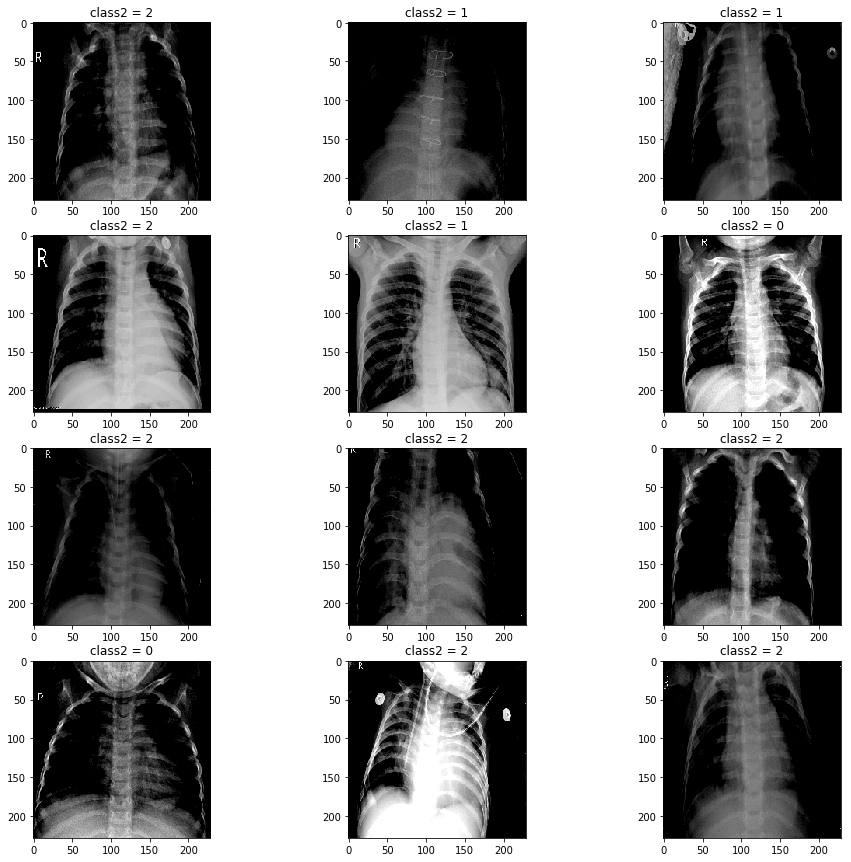

In [12]:
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from functools import partial

IMAGE_SIZE = img_width, img_height

# this is the augmentation configuration we will use for training
# For test we don't need to apply transformation
test_datagen = None

def resize_img(img, resize):
    return cv2.resize(img, resize) 

def img_normalization(img):
    if img is None:
        raise Exception("No input image")
    img = img.astype(np.float32)
    img /= 127.5
    img -= 1.0
    return img

def normalization_fn(img, resize=(112, 112)):
    img = img_normalization(img)
    img = resize_img(img, resize=resize)
    return img

def load_and_preprocess_rgb(path):
    img = cv2.imread(path)
    if img is None:
        raise Exception("unable to read: %s" % path)
    if len(img.shape) == 1 or img.shape[2] ==1:
        #print("COLOR_GRAY2RGB")
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


# augmentation
import imgaug.augmenters as iaa

sometimes = lambda aug: iaa.Sometimes(0.7, aug)

# Augmentation sequence 
seq = iaa.Sequential(
    [
        sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.05),
            #pad_mode=ia.ALL,
            pad_mode='constant',
            pad_cval=(0, 1)
        )),
        
        sometimes(iaa.Affine(
            scale={"x": (1., 1.1), "y": (1., 1.1)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.05, 0.05), "y": (-0.02, 0.02)}, # translate by -20 to +20 percent (per axis)
            #rotate=(-5, 5), # rotate by -45 to +45 degrees
            #shear=(-8, 8), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 1), # if mode is constant, use a cval between 0 and 255
            #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            mode='constant' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
    ],
    random_order=True
    )

# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    #iaa.Affine(rotate=20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

seq = iaa.Sequential(
    [
        iaa.OneOf([
                  iaa.Fliplr(), # horizontal flips
                  #iaa.Affine(rotate=20), # roatation
                  iaa.Multiply((1.2, 1.5))]), #random brightness

        sometimes(iaa.Affine(
            scale={"x": (1., 1.1), "y": (1., 1.1)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.05, 0.05), "y": (-0.02, 0.02)}, # translate by -20 to +20 percent (per axis)
            #rotate=(-5, 5), # rotate by -45 to +45 degrees
            #shear=(-8, 8), # shear by -16 to +16 degrees
            order=[0, 1], # use nearest neighbour or bilinear interpolation (fast)
            cval=(0, 1), # if mode is constant, use a cval between 0 and 255
            #mode=ia.ALL # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            mode='constant' # use any of scikit-image's warping modes (see 2nd image from the top for examples)
        ))
    ],
    random_order=True
    )

def aug_fn(img, seq):
    images_aug = seq.augment_image(img)  
    return images_aug

train_generator = DataLoaderSig(df=df_protocol2[df_protocol2.Set == 'train'], 
                                 batch_size=32,
                                 stratify='Class2', 
                                 image_shape=input_shape, 
                                 normalization_fn=partial(normalization_fn, resize=IMAGE_SIZE),
                                 nb_classes=nbClasses, shuffle=True, 
                                 load_and_preprocess_fn=load_and_preprocess_rgb,
                                 dataAugmentator=partial(aug_fn, seq=seq),
                                 path_and_class_translation_fn=partial(path_and_one_hot_class2_translation_fn,
                                                                   nb_classes=nbClasses,
                                                                   base_path=INPUT_DIR) )

val_generator = DataLoaderSig(df=df_protocol2[df_protocol2.Set == 'val'],
                               batch_size=32, stratify='Class2', 
                               image_shape=input_shape, 
                               normalization_fn=partial(normalization_fn, resize=IMAGE_SIZE),
                               nb_classes=nbClasses, shuffle=True, 
                               load_and_preprocess_fn=load_and_preprocess_rgb,
                               dataAugmentator=None,
                               path_and_class_translation_fn=partial(path_and_one_hot_class2_translation_fn,
                                                                   nb_classes=nbClasses,
                                                                   base_path=INPUT_DIR) )

test_generator = DataLoaderSig(df=df_protocol2[df_protocol2.Set == 'test'],
                                batch_size=32, stratify='Class2', 
                                image_shape=input_shape,
                                nb_classes=nbClasses, 
                                normalization_fn=partial(normalization_fn, resize=IMAGE_SIZE),
                                shuffle=True, 
                                load_and_preprocess_fn=load_and_preprocess_rgb,
                                dataAugmentator=None,
                                path_and_class_translation_fn=partial(path_and_one_hot_class2_translation_fn,
                                                                   nb_classes=nbClasses,
                                                                   base_path=INPUT_DIR) )

X, y = train_generator.__getitem__(2)
#print(X.shape, y.shape)

total = min(15, X.shape[0])
f, axes = plt.subplots(4, 3, figsize=(16, total) )
for idx in range(total):
    img =  X[idx]
    normal, bacteria, virus = y['normal'][idx],y['bacteria'][idx],y['virus'][idx]

    axes[idx // 4, idx % 3].imshow(img, interpolation='nearest')
    axes[idx // 4, idx % 3].set_title('class2 = %d' % np.argmax((normal, bacteria, virus)))
    axes[idx // 4, idx % 3].grid('off')
plt.show()


# Gera o modelo

In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.applications import xception
from keras.models import Model
import keras.regularizers as regularizers

K.clear_session()

NB_CLASSES = 3
IMAGE_SIZE = (img_height, img_width)

from keras.regularizers import l2

base_model = xception.Xception(include_top=True, weights='imagenet', input_shape=input_shape)

# Freeze layers
xception_cut_layer = 'add_2'
for layer in base_model.layers:
    layer.trainable = False
    if layer.name == xception_cut_layer:
        break

X = base_model.get_layer('avg_pool').output
#Dropout with probability dropout
X = Dropout(0.5, name='dropout')(X)

#FC layer with nb_classes neurons and softmax activation
out_normal = Dense(1, activation='sigmoid', name='normal',
                   kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
                   kernel_initializer='glorot_normal')(X)

out_bacteria = Dense(1, activation='sigmoid', name='bacteria',
                   kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
                   kernel_initializer='glorot_normal')(X)

out_virus = Dense(1, activation='sigmoid', name='virus',
                   kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3),
                   kernel_initializer='glorot_normal')(X)

model = Model(inputs=base_model.input,
              outputs=[out_normal, out_bacteria, out_virus])
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 229, 229, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 114, 114, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 114, 114, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 114, 114, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

## Parâmetros de compilação

In [14]:
import keras.optimizers as optimizers
import tensorflow as tf

# Save model definition to json
with open("./%s.1_definition.json" % MODEL_ID, 'w') as model_file:
    model_file.write(model.to_json())

losses = {'normal': 'binary_crossentropy',
          'bacteria': 'binary_crossentropy',
          'virus': 'binary_crossentropy'}

loss_weights =  {'normal': 0.6,
                 'bacteria': 0.2,
                 'virus': 0.2}
# Compilation
model.compile(optimizer=optimizers.Adam(lr=1e-5), 
              loss=losses,
              loss_weights=loss_weights,
              metrics=['acc'])

# Compile and train CNN, using Adam optimizer ## 1e-3
#model.compile(loss='categorical_crossentropy', optimizer=get_adam(1e-5), metrics=['acc'])


## Treinamento

In [15]:
epochs = 100
batch_size = 64

import keras.callbacks

# Save weights of best model, according to validation loss criteria  
checkpoints = keras.callbacks.ModelCheckpoint("./%s.1_best_val_acc.weights" % MODEL_ID, 
                                              monitor='val_loss', verbose=1,
                                              save_best_only=True, save_weights_only=True, 
                                              period=1)

# Stop training after 10 epochs without an improvement of at least 1e-4 in val_acc
earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                  patience=10, verbose=1)


# Reduce LR by 20% after 4 epochs without improvements of at least 1e-3 on val_loss
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                              factor=0.8, 
                                              patience=4, 
                                              verbose=1, 
                                              mode='auto')


callbacks_list = [earlystop, checkpoints, reduce_lr]

#Fit nos dados
history =  model.fit_generator(train_generator, 
                               steps_per_epoch= TRAINING_PERCENTAGE * len(train_generator), 
                               epochs = epochs,
                               validation_data = val_generator,  
                               validation_steps = len(val_generator),
                               callbacks=callbacks_list)



Epoch 1/100
406/406 [==============================] - 683s 2s/step - loss: 0.4142 - normal_loss: 0.2882 - bacteria_loss: 0.5411 - virus_loss: 0.5709 - normal_acc: 0.9078 - bacteria_acc: 0.7241 - virus_acc: 0.6736 - val_loss: 0.2648 - val_normal_loss: 0.1135 - val_bacteria_loss: 0.4332 - val_virus_loss: 0.4549 - val_normal_acc: 0.9690 - val_bacteria_acc: 0.8069 - val_virus_acc: 0.7901
Epoch 2/100
406/406 [==============================] - 628s 2s/step - loss: 0.2157 - normal_loss: 0.0639 - bacteria_loss: 0.3889 - virus_loss: 0.4028 - normal_acc: 0.9837 - bacteria_acc: 0.8197 - virus_acc: 0.8088 - val_loss: 0.2008 - val_normal_loss: 0.0528 - val_bacteria_loss: 0.3597 - val_virus_loss: 0.3903 - val_normal_acc: 0.9865 - val_bacteria_acc: 0.8389 - val_virus_acc: 0.8195
Epoch 3/100
406/406 [==============================] - 617s 2s/step - loss: 0.1723 - normal_loss: 0.0320 - bacteria_loss: 0.3332 - virus_loss: 0.3365 - normal_acc: 0.9911 - bacteria_acc: 0.8475 - virus_acc: 0.8450 - val_loss

Epoch 14/100
406/406 [==============================] - 550s 1s/step - loss: 0.0292 - normal_loss: 0.0022 - bacteria_loss: 0.0230 - virus_loss: 0.0232 - normal_acc: 0.9998 - bacteria_acc: 0.9939 - virus_acc: 0.9949 - val_loss: 0.2765 - val_normal_loss: 0.0554 - val_bacteria_loss: 0.5536 - val_virus_loss: 0.5701 - val_normal_acc: 0.9851 - val_bacteria_acc: 0.8380 - val_virus_acc: 0.8337
Epoch 00014: early stopping


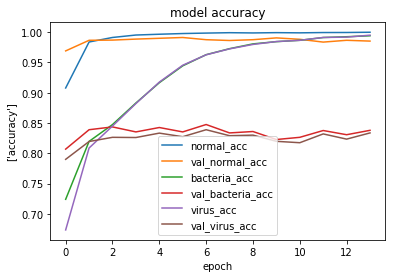

In [16]:

# summarize history for accuracy
plt.plot(history.history['normal_acc'])
plt.plot(history.history['val_normal_acc'])
plt.plot(history.history['bacteria_acc'])
plt.plot(history.history['val_bacteria_acc'])
plt.plot(history.history['virus_acc'])
plt.plot(history.history['val_virus_acc'])

plt.title('model accuracy')
plt.ylabel(['accuracy'])
plt.xlabel('epoch')
plt.legend(['normal_acc', 'val_normal_acc','bacteria_acc', 'val_bacteria_acc','virus_acc', 'val_virus_acc'], loc='best')
plt.show()

In [17]:
model.load_weights("%s.1_best_val_acc.weights" % MODEL_ID)


Normalized confusion matrix
('validation norm. accuracy: ', 0.8267326732673267)


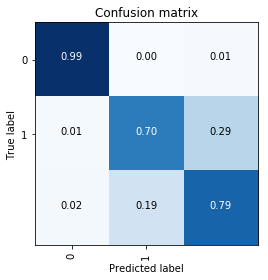

In [18]:
# evaluate validation set

Y_predicted=[]
Y_true=[]
for i in range(len(val_generator)):
    v = val_generator.__getitem__(i)
    x,y = v
    
    Y = []
    for idx in range(len(y['normal'])):
        img =  X[idx]
        normal, bacteria, virus = y['normal'][idx],y['bacteria'][idx],y['virus'][idx]
        label = np.argmax((normal, bacteria, virus))
        Y.append(label)
    pred = model.predict(np.array(x))
    pred = np.array(pred)

    # get class
    pred = [np.argmax(np.array([pred[0][i], pred[1][i], pred[2][i]])) for i in range(len(pred[0]))]

    Y_predicted.extend(pred)
    Y_true.extend(Y)

# Confusion matrix
import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=Y_true, y_pred=Y_predicted)
cm = plot_confusion_matrix(cm, range(2), normalize=True,
                           title='Confusion matrix',
                           width=4,cmap=plt.cm.Blues)

print("validation norm. accuracy: ",
      metrics.accuracy_score(Y_true, Y_predicted, normalize=True))


Normalized confusion matrix
('validation 2-classes norm. accuracy: ', 0.9867986798679867)


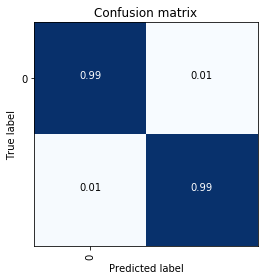

In [19]:
# 2 classes (Normal vs Pneumonia)
Y_predicted =  1*  ([(y > 0) for y in Y_predicted])
Y_true =  1*  ([(y > 0) for y in Y_true])

# Confusion matrix
#print(Y_predicted)
#print(Y_true)
cm = metrics.confusion_matrix(y_true=Y_true, y_pred=Y_predicted)
cm = plot_confusion_matrix(cm, range(1), normalize=True,
                           title='Confusion matrix',
                           width=4,cmap=plt.cm.Blues)

print("validation 2-classes norm. accuracy: ",
      metrics.accuracy_score(Y_true, Y_predicted, normalize=True))

# Avalia teste

Normalized confusion matrix
('validation norm. accuracy: ', 0.80625)


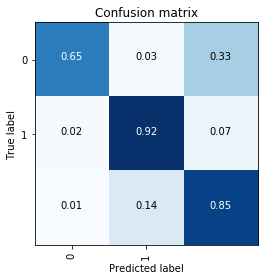

In [20]:
# evaluate test set

Y_predicted=[]
Y_true=[]
for i in range(len(test_generator)):
    v = test_generator.__getitem__(i)
    x,y = v
    
    Y = []
    for idx in range(len(y['normal'])):
        img =  X[idx]
        normal, bacteria, virus = y['normal'][idx],y['bacteria'][idx],y['virus'][idx]
        label = np.argmax((normal, bacteria, virus))
        Y.append(label)
    pred = model.predict(np.array(x))
    pred = np.array(pred)

    # get class
    pred = [np.argmax(np.array([pred[0][i], pred[1][i], pred[2][i]])) for i in range(len(pred[0]))]

    Y_predicted.extend(pred)
    Y_true.extend(Y)

# Confusion matrix
import sklearn.metrics as metrics
cm = metrics.confusion_matrix(y_true=Y_true, y_pred=Y_predicted)
cm = plot_confusion_matrix(cm, range(2), normalize=True,
                           title='Confusion matrix',
                           width=4,cmap=plt.cm.Blues)

print("validation norm. accuracy: ",
      metrics.accuracy_score(Y_true, Y_predicted, normalize=True))


Normalized confusion matrix
('test 2-classes norm. accuracy: ', 0.8743055555555556)


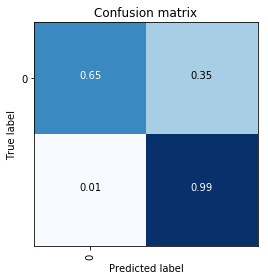

In [21]:
# 2 classes (Normal vs Pneumonia)
Y_predicted =  1*  ([(y > 0) for y in Y_predicted])
Y_true =  1*  ([(y > 0) for y in Y_true])

# Confusion matrix
#print(Y_predicted)
#print(Y_true)
cm = metrics.confusion_matrix(y_true=Y_true, y_pred=Y_predicted)
cm = plot_confusion_matrix(cm, range(1), normalize=True,
                           title='Confusion matrix',
                           width=4,cmap=plt.cm.Blues)

print("test 2-classes norm. accuracy: ",
      metrics.accuracy_score(Y_true, Y_predicted, normalize=True))

#### 

In [22]:
import gc
gc.collect()

3220

## Extract features from the last layer before classification

In [23]:
model.load_weights("%s.1_best_val_acc.weights" % MODEL_ID)

#Global Average Pooling    
x = model.get_layer('avg_pool').output

fv_model = Model(inputs=model.input, outputs=x)
fv_model.compile(optimizer=optimizers.Adam(lr=1e-5), 
              loss="categorical_crossentropy",
              metrics=['acc'])

### Extract features

In [24]:

YLabels, FV = [], []
for i in range(len(val_generator)):
    v = val_generator.__getitem__(i)
    x,y = v

    Y = []
    for idx in range(len(y['normal'])):
        img =  X[idx]
        normal, bacteria, virus = y['normal'][idx],y['bacteria'][idx],y['virus'][idx]
        label = np.argmax((normal, bacteria, virus))
        Y.append(label)
    
    pred = fv_model.predict(np.array(x))
    
    pred = np.array(pred)
    #print(pred.shape)
    
    YLabels.extend(Y)
    # append FV
    for i in range(pred.shape[0]):
        FV.append(pred[i])


In [25]:
del(fv_model)
del(model)

import gc
gc.collect()

306

### Utiliza T-sne para visualizar a distribuição dos dados

In [26]:

from time import time
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold

n_components = 2
t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
pos_tsne = tsne.fit_transform(FV)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))



t-SNE: 90 sec


/usr/local/lib/python2.7/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


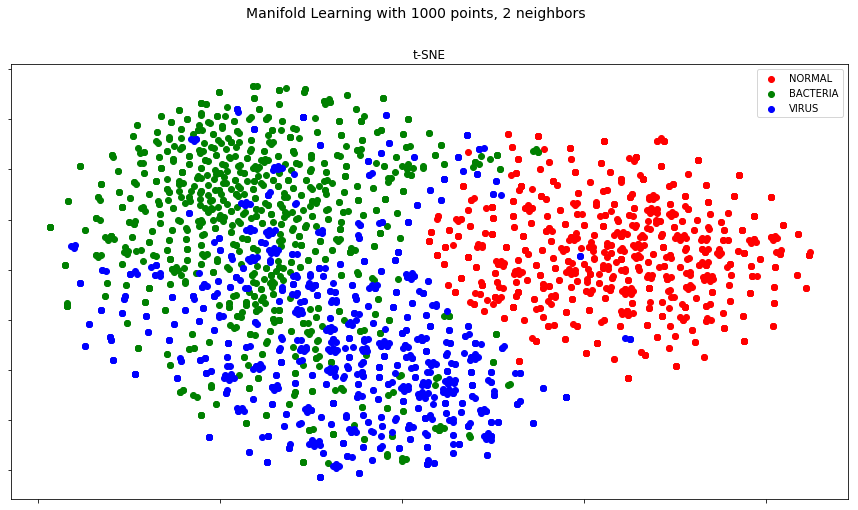

In [27]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_components), fontsize=14)

class_0_idx = [i for i in range(len(YLabels)) if YLabels[i] == 0]
class_1_idx = [i for i in range(len(YLabels)) if YLabels[i] == 1]
class_2_idx = [i for i in range(len(YLabels)) if YLabels[i] == 2]

# plot in 2 components
plt.scatter(pos_tsne[class_0_idx, 0], pos_tsne[class_0_idx, 1], c=["r"], cmap=plt.cm.Spectral)
plt.scatter(pos_tsne[class_1_idx, 0], pos_tsne[class_1_idx, 1], c=["g"], cmap=plt.cm.Spectral)
plt.scatter(pos_tsne[class_2_idx, 0], pos_tsne[class_2_idx, 1], c=["b"], cmap=plt.cm.Spectral)
ax = fig.add_subplot(111)
plt.title("t-SNE" )
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')
ax.legend(('NORMAL', 'BACTERIA', 'VIRUS'),
           loc='upper right')
plt.show()


